# AnomalyDetection_4_MovingAverage

**Updates from previous notebook:** 
- this notebook follows the moving average idea from AnomalyDetection_3_Problem_1
   

## Libraries and Configuration

In [17]:
""" Libraries """

#file / system libraries 
import os
import datetime as dt

# mathematical 

from numpy.fft import ifft
from numpy.fft import fft
import numpy as np

# data exploration

import pandas as pd

# data visualization

import matplotlib.pyplot as plt

""" Configuration """

# pandas 

pd.set_option('display.max_columns', None)

## Functions

In [18]:
def polynomial(x):
    """ takes an array and returns it after our polynomial function has been applied to it"""
    C = [0.7741697399557282,-0.15839741967042406,0.09528795099596377,-0.004279871380772796]
    y = C[0]*np.power(x,4)+C[1]*np.power(x,2)+C[2]*x+C[3]
    return y

def directory_to_df(paths, exclude = [None], filetype = '.csv',ignore_index = True, exception = '_repet'):
    """ concatenates all files in a directory into a dataframe
    components:
    path: path to the directory (must end with /)
    exclude: array of directories to excludes from the treatment
    filetype: a string of the file extension (must include .)
    ignore_index: boolean that tells pandas to ignore the index or not
    exception: takes a string. Any time a filename includes this string it is treated differently (for cases when you have
    more than one ) 
    """
    filenames = []
    file_column = []
    frames = []
    test_index = 1
    
    for path in paths:
        for filename in os.listdir(path):
            print(path)
            if filetype in filename and filename not in exclude:
                if exception in filename:
                    curr_df = pd.read_csv(path+filename)
                    curr_df = special_treatment(curr_df)
                    
                else:
                    curr_df = pd.read_csv(path+filename)                    
                frames.append(curr_df)
                filenames.append(filename.replace(filetype,''))
                for i in range(curr_df.shape[0]):
                    file_column.append(test_index)
                test_index+=1

    df = pd.concat(frames,ignore_index = ignore_index)
    df['files'] = file_column
    return df, filenames


def special_treatment(df):
    """ performs a custom operation on a dataframe
    components:
    df: dataframe to play on
    """
    columns = df.columns.values.tolist()
    columns.remove('date')
    df.drop('gyrZ',inplace = True, axis = 1)
    df.columns = columns
    df.reset_index(inplace = True)
    df.rename(columns= {'index':'date'},inplace = True)
    return df

class seasonality():
    """ takes in a dataframe, outputting it with two extra columns: seasonality (but column name = seasonality
    inputted) and times, where 'times' is a plottable version of date with reference to a prespecified start time
    (day_start)
    Components:
    df: the dataframe, must have the dates column as 'date' and in np.datetime64 timeformat
    seasonality (optional): defaults to 'day'. This is the criteria for splitting the data
    day_start (optional): this signifies what is the 'start time' of the day (i.e. the 0 point on the x axis). Defaults
    for midnight.
    time_delta (optional): this defines the units for the time delta between data points. Defaults to seconds.
    EDIT THIS MSG
    NEED TO FIX THIS
    """ 
    def __init__(self,df,seasonality='day',day_start = '00:00:00', time_delta = 's'):
        
        if seasonality not in ['hour','day','month','year']:
            raise ValueError("you can only input the following for seasonality: 'day', 'month', or 'year'")
        self.df = df
        self.seasonality = 'seasonality_{}'.format(seasonality)
        try:
            self.day_start = dt.datetime.strptime(day_start,'%H:%M:%S')
        except:
            raise ValueError('Please enter your day_start in the correct format: "HH:MM:SS". "{}" is not acceptable'\
                             .format(day_start))
        self.time_delta = time_delta

    def find_seasonal_trends(self):
        if 'hour' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.hour
        elif 'day' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.day
        elif 'month' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.month
        else:
            self.df[self.seasonality] = self.df.date.dt.year
            
        self.create_times()


        return self.df
    
    def create_times(self):
        times = []
        for season in self.df[self.seasonality].unique():
            temp_dates = self.df.date[self.df[self.seasonality] == season].values
            date = dt.datetime.strptime(str(temp_dates[0])[:-3], '%Y-%m-%dT%H:%M:%S.%f')
            # 'date' is wrong: this will not work for when you have a lower order seasonality.
            # it needs to adapt such that it starts recording when the beginning of the year
            start_day = dt.datetime(date.year,
                                    date.month,
                                    date.day,
                                    self.day_start.hour,
                                    self.day_start.minute,
                                    self.day_start.second)
            start_day = np.datetime64(start_day)
            
            for index, date in enumerate(temp_dates):
                times.append((date - start_day)/np.timedelta64(1, self.time_delta))
        self.df['times'] = times

## Data

In [19]:
base = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/{}'
names = ['rohan','ignacio']
end_labels = ['_filtered.csv']
dfs = []

for index,name in enumerate(names):
    dfs.append(pd.read_csv(base.format(names[index]+end_labels[0]),index_col = 0))

In [20]:
dfs[0].head()

,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
220,2020-09-14 19:19:26,0.01,0.02,0.00,3.62,1.04,1.38,1,0.022361,4.011284
319,2020-09-14 19:20:39,0.09,0.16,0.14,36.11,25.84,67.85,1,0.230868,81.087978
320,2020-09-14 19:20:40,0.09,0.16,0.09,22.98,15.43,16.45,1,0.204450,32.198879
321,2020-09-14 19:20:41,0.05,0.07,0.09,22.98,15.43,16.45,1,0.124499,32.198879
322,2020-09-14 19:20:42,0.12,0.07,0.07,29.44,39.83,27.27,1,0.155563,56.540210


In [21]:
dfs[1].head()

,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
0,2020-09-13 17:09:25,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784
1,2020-09-13 17:09:26,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784
2,2020-09-13 17:09:27,0.01,0.01,0.00,7.43,6.82,10.10,1,0.014142,14.273307
12,2020-09-13 17:09:34,0.01,0.01,0.00,6.64,7.07,12.45,1,0.014142,15.782173
13,2020-09-13 17:09:34,0.01,0.01,0.00,4.12,3.61,5.81,1,0.014142,7.985149


In [22]:
import datetime as dt

class moving_avg:
    """
    a class used to store a moving average values, parameters
    
    Dependencies:
    -------------
    
    
    Attributes:
    -----------
    
    averages: [*float]
        stores the values of the moving average at each datapoint
    
    time_frame ( optional - 5 ): int
        the window for the moving average, in hours
        
    weight ( optional - (0.0, 0.75) ): (float, float)
        weight to apply to numbers greater than the specified quartile
        
    time_frame_start: datetime
        the start of the moving average window
        
    Methods:
    --------
        
    """
    averages = [[0.0,0.0]]
    
    num_points = []
    
    points = []
    sum_points = [[0.0, 0.0]]
    time_frame_start = [dt.datetime.strptime('1999-07-24 00:00:00','%Y-%m-%d %H:%M:%S')]
    time_stamps = []
    
    def __init__( self, time_frame = 5, weight = (0.0, 0.75)):

        self.time_frame = time_frame*3600
        self.weight = weight

    def plot():
        pass # for plotting purposes
    
    
class average(moving_avg):
    """
    
    Dependencies:
    -------------
    
    
    
    Attributes:
    -----------
    
    data: [float, float, float, float, float, float]
        represents the list of the seven readings, averaged out over the second:
        [AccX, AccY, AccZ, GyrX, GyrY, GyrZ, Fall]
        Acceleration units are in g, Gyration in degrees per second
        

        
    """
    
    def __init__(self,data,time):
        super().__init__()

        self.data = data
        self.time_stamps.append(dt.datetime.strptime(time,'%Y-%m-%d %H:%M:%S'))
        
        self.points.append([
            data_point for data_point in self.data
        ]
        )
        
        
            
        if not moving_avg.num_points:
            self.time_frame_start[-1] = self.time_stamps[-1]
            
        if (self.time_stamps[-1] - self.time_frame_start[-1]).total_seconds() >= self.time_frame: 
            self.update_attributes()        

        
        self.average()
        
    def average(self):
        # need to know the index that we are dealing with!  
        # need to know index of self.time_frame_start !
        # so, from index of self.time_frame_start[-1], until the end of the list, sum all thevalues
        
        our_index = len(self.time_frame_start) - 1
        our_range = len(self.points) - our_index
        self.num_points.append(our_range)
        
        
        for i in range(len(self.sum_points[-1])):
            
            for j in range(our_index, len(self.points) - 1):
                
                self.sum_points[-1][i] += self.points[j][i]
        
        #print(self.points)
        #print(self.sum_points)
            
        self.averages[-1] = [sum_point/self.num_points[-1] for sum_point in self.sum_points[-1]]

    def update_attributes(self):
        
        self.time_frame_start.append(
            self.time_stamps[
                self.time_stamps.index(
                    self.time_frame_start[-1]
                ) + 1
            ]
        )
        our_index = self.time_stamps.index(self.time_frame_start[-1]) - 1
        self.num_points.append(len(self.points[our_index:]))
        print(self.num_points)
        self.sum_points.append([0.0,0.0])
        self.averages.append(0)
        


data = [2,3]
instance = average(data,'1999-07-24 00:00:00')
data = [3,4]
instance = average(data,'1999-07-24 04:00:00')
data = [90,10]
instance = average(data,'1999-07-24 05:00:00')

data = [5,6]
instance = average(data,'1999-07-24 5:01:00')
data = [8,9]

instance = average(data,'1999-07-24 5:02:00')


moving_avg.averages


[1, 2, 3]


[[1.0, 1.5], [48.5, 9.5]]

In [380]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

class moving_avg:

    """
    a class used to store a moving average values, parameters and methods
    
    Dependencies:
    -------------
    import datetime as dt
    import numpy as np
    import matplotlib.pyplot as plt
    
    Attributes:
    -----------
    
    data ( class var ): [*[*float]]
        stores all the datapoints for each window
        
    time_frame_start ( class var ): [datetime]
        the start of the moving average window
    
    time_stamps ( class var ): [*[*datetime]]
        stores the timestamps for each data point within it's window
        
    averages ( class var ): [*float]
        stores the values of the moving average for each window    
        
    time_frame ( optional - 5 ): int
        the length of the moving window in units of hours
        
    weight ( optional - (0.0, 0.75) ): (float, float)
        weight to apply to numbers greater than the specified quartile
    
        
    Methods:
    --------
    __init__( self, time_frame = 5, weight = (0.0, 0.75)):
    initialises class based on inputs; converts 'time_frame' to seconds

    
    average( self ):
        calculates the averages for each moving window
        
    plot( self, figsize = (16,8), labels = ('gyrTotal', ' accTotal') ): 
        plots the averages against the start time of the moving moving
        
    """
    data = [[]]
    time_frame_start = []
    time_stamps = [[]]
    averages = []
    # note there is a danger in using class variables because they 'save' every instantiations values!
    
    def __init__( self, time_frame = 5, weight = (0.0, 0.75)):
        self.time_frame = time_frame*3600
        self.weight = weight
        
    def average( self ):   
        for window in self.data:
            window = np.asarray(window).reshape(-2,2)
            self.averages.append([
                window[:,index].mean() for index in range(window.shape[1])
            ])


    def plot( self, figsize = (16,8), labels = ('gyrTotal', ' accTotal') ):
        averages = np.asarray(self.averages).reshape((-2,2))
        fig = plt.figure(figsize = figsize)
        for i in range(averages.shape[1]):
            fig.add_subplot(1,averages.shape[1],i+1)
            #plt.plot(self.time_frame_start,averages[:,i],'.')
            #plt.plot([j for j in range(len(self.time_frame_start))],averages[:,i],'.')
            
            plt.plot([j for j in range(averages.shape[0])],averages[:,i],'.')
            #plt.xticks(self.time_frame_start)
            plt.xlabel('date')
            plt.ylabel('average {}'.format(labels[i]))

        plt.show()


class average(moving_avg):
    """
    
    Dependencies:
    -------------
    moving_avg (class)
    
    Attributes:
    -----------
    
    datapoint: [*float]
        datapoint to be considered for averaging, length --> degrees of freedom
    
    time: str
        time data point is recorded in the format 'YYYY-mm-dd HH:MM:SS'
        
    Methods:
    --------
    
    __init__(self, datapoint, time):
        initilises class; converts time to datetime; stores new datapoint and time;
        if new time exceeds average window, creates new storage location
        
    """
    
    def __init__(self,datapoint,time):
        super().__init__() # is this necessary?

        self.datapoint = datapoint
        self.time_stamps[-1].append(dt.datetime.strptime(time,'%Y-%m-%d %H:%M:%S'))
        
        if not self.time_frame_start:
            self.time_frame_start.append(self.time_stamps[-1][-1])
        if (self.time_stamps[-1][-1] - self.time_frame_start[-1]).total_seconds() < self.time_frame:
            pass
        else:
            for i,time in enumerate(self.time_stamps[-1]):
                if time not in self.time_frame_start:
                    self.data.append(
                        self.data[-1][1:]
                    )

                    self.time_frame_start.append(time)
                    
            self.data.append([])

            """ self.time_frame_start.append(
                self.time_stamps[-1][
                    self.time_stamps[-1].index(
                        self.time_frame_start[-1]
                    ) + 1
                ]
            )
            self.data.insert(
                len(self.time_frame_start) - 1,
                self.data[len(self.time_frame_start) - 2][1:]
            )"""
            
            
            
        self.data[-1].append([
            point for point in datapoint
        ]) # should account for the 'weights' that you've specified here, might require moving the average method
        
# what the class is still missing is the 'decision making process', so if an average is lower than 

## On read data

In [331]:
# shows values which are MUCH lower than their previous value

averages = np.asarray(m_avg_instance.averages).reshape(-2,2)
print(averages.shape)
for index in range(1,(averages[:,1]).shape[0]):
    if averages[index,1] < 0.1*averages[index - 1, 1]:
        plt.plot(index,averages[index,1],'+')

(69, 2)


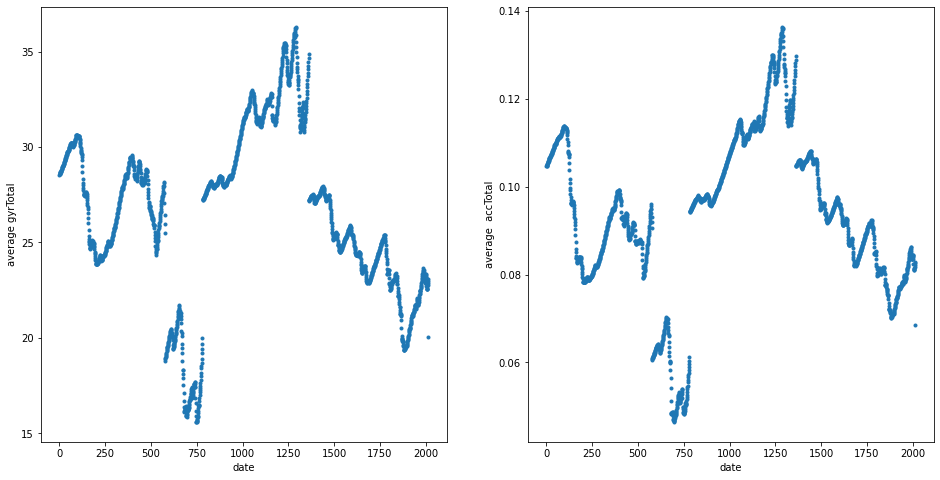

In [377]:
m_avg_instance = moving_avg()
for item in dfs[1][['gyrTotal','accTotal','date']].values.tolist():
    avg_instance = average(item[0:2],item[2])
m_avg_instance.average()
m_avg_instance.plot()



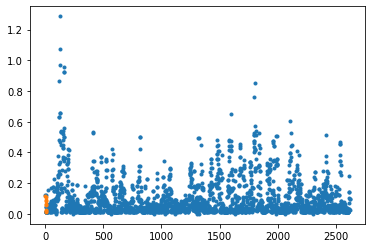

In [297]:
#dfs[0].reset_index(inplace = True)
#dfs[1].reset_index (inplace = True)
averages = np.asarray(m_avg_instance.averages).reshape(-2,2)

plt.plot(dfs[1].index,dfs[1].accTotal,'.')
plt.plot([i for i in range(len(m_avg_instance.averages))],averages[:,1],'.')


# does not seem to be working... the graphs seems to have just 'shifted place...' what is the meaning of this?
# this is very confusing, because it was working well earlier...

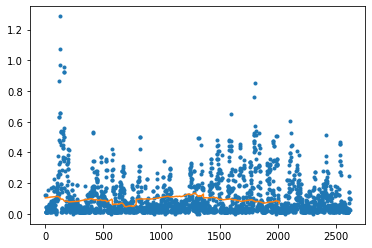

In [382]:
newinstance = moving_avg()
for item in dfs[1][['gyrTotal','accTotal','date']].values.tolist():
    avg_instance = average(item[0:2],item[2])

newinstance.average()

plt.plot(dfs[1].index,dfs[1][['gyrTotal','accTotal','date']].values[:,1],'.')

plt.plot([i for i in range(len(newinstance.averages))],np.asarray(newinstance.averages).reshape(-2,2)[:,1])

In [158]:
df_walk = df_testing[df_testing.files == 4]
x = df_walk.accTotal
f, Pxx_den = signal.periodogram(x, 1) 
f, Pxx_den = signal.welch(x, 1, nperseg=1024)
plt.plot(f,Pxx_den/58)



df_walk = df_testing[df_testing.files == 5]
x = df_walk.accTotal
f, Pxx_den = signal.periodogram(x, 1) 
f, Pxx_den = signal.welch(x, 1, nperseg=1024)
plt.plot(f,Pxx_den/49)



df_walk = df_testing[df_testing.files == 2]
x = df_walk.accTotal
f, Pxx_den = signal.periodogram(x, 1) 
f, Pxx_den = signal.welch(x, 1, nperseg=1024)
plt.plot(f,Pxx_den/57)



"""df_walk = df_testing[df_testing.files == 1]
x = df_walk.accTotal
f, Pxx_den = signal.periodogram(x, 1) 
f, Pxx_den = signal.welch(x, 1, nperseg=1024)
plt.plot(f,Pxx_den/53)
"""


df_walk = df_testing[df_testing.files == 9]
x = df_walk.accTotal
f, Pxx_den = signal.periodogram(x, 1) 
f, Pxx_den = signal.welch(x, 1, nperseg=1024)
plt.plot(f,Pxx_den/53)


plt.show()

NameError: name 'df_testing' is not defined

/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 1024 is greater than input length  = 149, using nperseg = 149
  .format(nperseg, input_length))
/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 1024 is greater than input length  = 49, using nperseg = 49
  .format(nperseg, input_length))


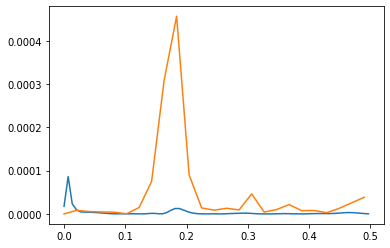

In [208]:
df_walk = df_testing[df_testing.files == 5]
x = df_walk.accTotal.values.tolist()
for i in range(100):
    x.append(0)
f, Pxx_den = signal.periodogram(x, 1) 
f, Pxx_den = signal.welch(x, 1, nperseg=1024)
plt.plot(f,Pxx_den/149)


df_walk = df_testing[df_testing.files == 5]
x = df_walk.accTotal.values.tolist()
f, Pxx_den = signal.periodogram(x, 1) 
f, Pxx_den = signal.welch(x, 1, nperseg=1024)
plt.plot(f,Pxx_den/49)

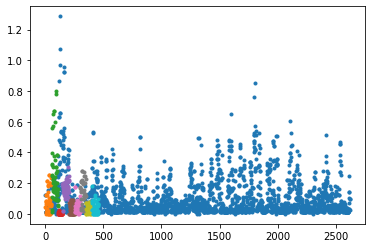

In [190]:
plt.plot(df_train.index,df_train.accTotal,'.')

for file in df_testing.files.unique():
    df_temp = df_testing[df_testing.files == file]
    plt.plot(df_temp.index,df_temp.accTotal,'.')


# Conclusion

Power seems to be a much better indicator than moving average... I am still not convinced by that.
Why?
Here are my concerns:
1. What do you choose as the time interval? This cannot actually be based on time, must be based on a number of points. If so, then since you've lost the DoF of time, then for one set of movement data, you might be capturing data over 1 min, or over 2 hrs, for the 1 min, the movement may not even be finished yet, but for the 2 hrs, it may have captured too many different movements?
2. The averages don't change that much, because of the data being right skewed. That said, there might need to be some sort of 'weighting' given to values that are greater than the upper quartile. What would this weighting be?
3. The second point does not fix the first point
4. Not sure how to combine acceleration and gyration?

Need to perhaps also understand how the Movement detection API works.


Another idea... what if you randomly sample the data for a set period (i.e. 1 hr for example), and then based on those results, calculate the power of the signal, and store it. Then you can train a neural network based on the power within the data, and then see if your result is anomalous or not? This would be interesting eh?